In [1]:
import os
import glob
import sys
import toml

from typing import List, Callable, Optional, Dict, NoReturn, Any, Union

import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from preproc import time_indexed_df, new_hybrid_interpolator, merge_on_duplicate_idx
from customobjs import objdict
help(time_indexed_df)

Help on function time_indexed_df in module preproc:

time_indexed_df(df1: pandas.core.frame.DataFrame, columname: str) -> pandas.core.frame.DataFrame
    Cast into a time-indexed dataframe.
    df1 paramater should have a column containing datetime-like data,
    which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
    or a string containing a compatible datetime (i.e. pd.to_datetime)



In [3]:
print(plt.style.available)
styles = plt.style.available

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [4]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [8]:
x = pd.read_csv(
    "comparative_trial_data/fml.txt", 
    sep="\t", index_col="Time", parse_dates=["Time"],
    
).drop(["ID"], axis="columns")
x = x.sort_index()
x.index[0], x.index[-1]

(Timestamp('2018-05-06 15:27:00'), Timestamp('2020-05-25 09:06:00'))

In [9]:
x = x["2020-05-12":"2020-05-25"]
x = merge_on_duplicate_idx(x, verbose=True)

 Total rows on source dataframe :	1362
 Duplicate indices :			121
 Total duplicate rows :			259
 Rows on pruned dataframe :		1299


In [10]:
with open("preproc.toml", "r") as f:
    config = toml.load(f, _dict=objdict)

In [11]:
x.columns

Index(['Record Type', 'Historic Glucose (mg/dL)', 'Scan Glucose (mg/dL)',
       'Non-numeric Rapid-Acting Insulin', 'Rapid-Acting Insulin (units)',
       'Non-numeric Food', 'Carbohydrates (grams)',
       'Non-numeric Long-Acting Insulin', 'Long-Acting Insulin (units)',
       'Notes', 'Strip Glucose (mg/dL)', 'Ketone (mmol/L)', 'N/A', 'N/A.1',
       'N/A.2', 'Previous Time', 'Updated Time'],
      dtype='object')

In [52]:
start = "2020-05-23"
end = "2020-05-25"
col = "Historic Glucose (mg/dL)"

In [57]:
config.interpolation.specs

{'methods': {'linear': 0.65, 'akima': 0.25, 'polynomial': 0.1},
 'direction': 'both',
 'limit': 300,
 'limit_area': 'inside',
 'order': 2}

In [58]:
config.interpolation.specs.limit = 300

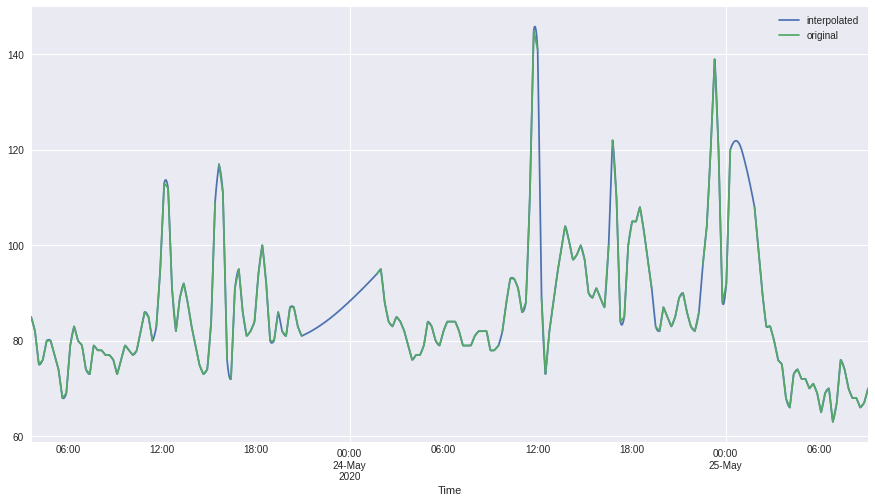

In [59]:
new_hybrid_interpolator(x[start:end][col].resample("1T").asfreq(), **config.interpolation.specs)\
    .plot(label="interpolated")
x[start:end][col]\
    .plot(label="original")
plt.legend()

In [60]:
y = x.resample("1T").asfreq()
y[col] = new_hybrid_interpolator(y[col],**config.interpolation.specs)

In [61]:
y[col].to_csv("faml_interpolated.csv")

,Record Type,Historic Glucose (mg/dL),Scan Glucose (mg/dL),Non-numeric Rapid-Acting Insulin,Rapid-Acting Insulin (units),Non-numeric Food,Carbohydrates (grams),Non-numeric Long-Acting Insulin,Long-Acting Insulin (units),Notes,Strip Glucose (mg/dL),Ketone (mmol/L),N/A,N/A.1,N/A.2,Previous Time,Updated Time
Time,,,,,,,,,,,,,,,,,
2020-04-25 00:05:00,1,NaN,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25 00:11:00,0,97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25 00:15:00,1,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25 00:26:00,0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-25 00:41:00,0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-08 13:02:00,1,NaN,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-08 13:16:00,0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-08 13:31:00,0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
help(pd.DataFrame.drop)

Help on function drop in module pandas.core.frame:

drop(self, labels=None, axis=0, index=None, columns=None, level=None, inplace=False, errors='raise')
    Drop specified labels from rows or columns.
    
    Remove rows or columns by specifying label names and corresponding
    axis, or by specifying directly index or column names. When using a
    multi-index, labels on different levels can be removed by specifying
    the level.
    
    Parameters
    ----------
    labels : single label or list-like
        Index or column labels to drop.
    axis : {0 or 'index', 1 or 'columns'}, default 0
        Whether to drop labels from the index (0 or 'index') or
        columns (1 or 'columns').
    index : single label or list-like
        Alternative to specifying axis (``labels, axis=0``
        is equivalent to ``index=labels``).
    
        .. versionadded:: 0.21.0
    columns : single label or list-like
        Alternative to specifying axis (``labels, axis=1``
        is equivalen